In [1]:
import scipy

import os
import numpy as np
import cv2

import tensorflow as tf
import subprocess
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import tensorflow_probability as tfp

import xplique
from xplique.attributions import *
from xplique.metrics import *

from xplique_addons import *
from utils import *

from explanation.face_interpret import FaceHsicAttributionMethod

import onnx_tf.backend
import onnx

import numpy as np
from PIL import Image
import torchvision.transforms as transforms

red_tr    = get_alpha_cmap('Reds')

2023-04-17 22:30:42.640625: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 22:30:42.681504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 22:30:43.319357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_18356/3636702644.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_

In [2]:
transforms = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

In [3]:
def prepare_image(path, size=112):
    img = Image.open(path)
    img = transforms(img).numpy()
    img = img.transpose(1, 2, 0)
    return img

In [4]:
class ONNX_model:
    def __init__(self, model_path):
        self.model_path = model_path
        onnx_model = onnx.load(self.model_path)
        self.model = onnx_tf.backend.prepare(onnx_model, device='CUDA')

    def __call__(self, inputs):
        assert len(inputs.shape) == 4
        inputs = inputs.transpose(0, 3, 1, 2)
        return self.model.run(inputs)[0]

In [5]:
batch_size = 128
model_path = "ckpt/ArcFace-R50-8631.onnx"

images_classes = [
                  ('image/n000002-0001_01.jpg', 0),
                  ('image/n000003-0002_01.jpg', 1),
                  ('image/n000004-0004_02.jpg', 2),
]
X_raw = np.array([prepare_image(p) for p, y in images_classes])
Y_true = np.array([y for p, y in images_classes])

tf_model = ONNX_model(model_path)

labels = np.argmax(tf_model(X_raw), axis=-1)
labels_ohe = tf.one_hot(labels, 8631)

2023-04-17 22:31:01.606586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1536,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-17 22:32:16.841908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'nb_dim' with dtype int64
	 [[{{node nb_dim}}]]
2023-04-17 22:32:16.843725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'nb_dim' with dtype int64
	 [[{{node nb_dim}}]]
2023-04-17 22:32:19.128909: I t

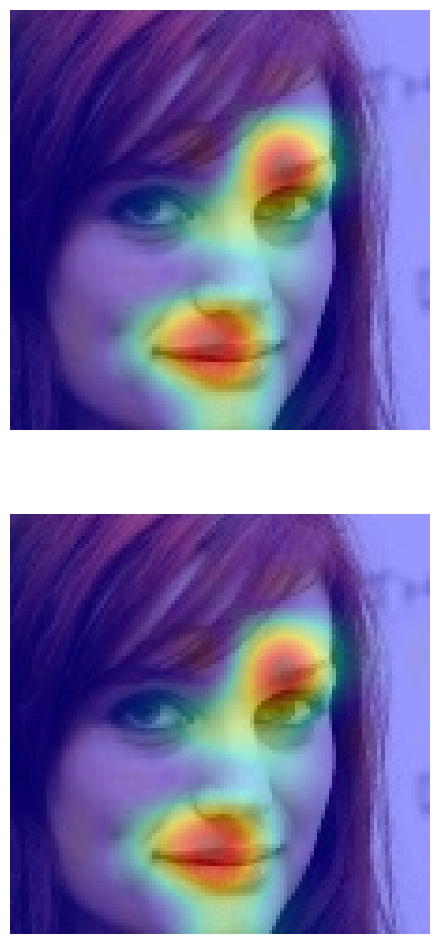

In [6]:
grid_size = 7
nb_forward = 1536

hsic_explainer = FaceHsicAttributionMethod(tf_model, 
                                      grid_size = grid_size, 
                                      nb_design = nb_forward , 
                                      sampler = HsicLHSSampler(binary=True), 
                                      estimator = HsicEstimator(kernel_type="binary"),
                                      perturbation_function = 'inpainting',
                                      batch_size = 256)

explanations = hsic_explainer(X_raw, labels_ohe)
explanations = np.array(explanations)

set_size(22, 12)
for i in range(2):
    plt.subplot(2, 1, i+1)
    show(X_raw[i])
    show(explanations[i], cmap="jet", alpha=0.4)
plt.show()

In [14]:
explanations.shape

(2, 112, 3)